### Backtesting for BUY HODL vs DCA

Buy-and-hold and dollar cost averaging (DCA) are two different investment strategies. This notebook compares the performance of these two strategies.

Buy-and-hold refers to buying assets at the start of the time period and holding the assets forever. 

DCA refers to buying the same value of assets at regular intervals.

In [2]:
import numpy as np
import pandas as pd
import misc
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns
import os

pd.options.display.max_columns=300
pd.options.display.max_rows=100


Dataset is SPY (S&P 500 ETF).

In [3]:
misc.get_price_data('SPY')
df = pd.read_csv('SPY.csv')
df = misc.clean_df(df)
df = df.set_index('date')
df

,open,high,low,close,adjclose,volume,ticker
date,,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,25.218246,1003200,SPY
1993-02-01,43.968750,44.250000,43.968750,44.250000,25.397585,480500,SPY
1993-02-02,44.218750,44.375000,44.125000,44.343750,25.451405,201300,SPY
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.720440,529400,SPY
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.828051,531500,SPY
...,...,...,...,...,...,...,...
2023-01-09,390.369995,393.700012,387.670013,387.859985,387.859985,73978100,SPY
2023-01-10,387.250000,390.649994,386.269989,390.579987,390.579987,65358100,SPY
2023-01-11,392.230011,395.600006,391.380005,395.519989,395.519989,68881100,SPY


BUY_HOLD => Buy on the 1st day (1993-01-29) and hold forever

DCA      => Buy every n days (DCA period) with equal amount of cash

All calculations are made based on adjusted close to take into dividends.

In [4]:
# Starting cash
starting_cash = 10000
df['cash'] = 0
df.loc[df.index[0], 'cash'] = starting_cash


# buy_hold benchmark
# buy on close of 1st day
# use adjclose to account for dividends
buy_hold_position = starting_cash / df['adjclose'][0]
df['buy_hold_total'] = buy_hold_position * df['adjclose']

# daily returns
df['buy_hold_daily_return'] = (df['buy_hold_total'] - df['buy_hold_total'].shift(1)) / df['buy_hold_total'].shift(1)

# peak
df['buy_hold_peak'] = df['buy_hold_total'][0]

# accummulated return
df['buy_hold_return'] = df['buy_hold_total'] / starting_cash - 1

for i in range(1, len(df)):
    # update peak
    if df['buy_hold_total'][i] > df['buy_hold_peak'][i - 1]:
        df.loc[df.index[i], 'buy_hold_peak'] = df['buy_hold_total'][i]
    else:
        df.loc[df.index[i], 'buy_hold_peak'] = df['buy_hold_peak'][i - 1]
# drawdown
df['buy_hold_drawdown'] = (df['buy_hold_total'] - df['buy_hold_peak']) / df['buy_hold_peak']



# dca benchmark
# divide history into n blocks of unit length t and invest starting_cash / n amount every t days
dca_period = 20
dca_num = len(df) / dca_period
dca_amount = np.floor(starting_cash / dca_num)

# cash remaining
dca_cash_remaining = starting_cash
df['dca_total'] = starting_cash
df['dca_peak'] = starting_cash
df['dca_drawdown'] = 0
dca_position = 0
df['dca_assets'] = 0
df['dca_cash'] = starting_cash

for i in range(1, len(df)):
    # invest every t days    
    if i % dca_period == 1:
        dca_position += dca_amount / df['adjclose'][i]
        dca_cash_remaining -= dca_amount
    # assets
    df.loc[df.index[i], 'dca_assets'] = dca_position * df['adjclose'][i]
    # cash
    df.loc[df.index[i], 'dca_cash'] = dca_cash_remaining
    # total
    df.loc[df.index[i], 'dca_total'] = df['dca_assets'][i] + df['dca_cash'][i]
    # peak
    if df['dca_total'][i] > df['dca_peak'][i - 1]:
        df.loc[df.index[i], 'dca_peak'] = df['dca_total'][i]
    else:
        df.loc[df.index[i], 'dca_peak'] = df['dca_peak'][i - 1]
# daily returns
df['dca_daily_return'] = (df['dca_total'] - df['dca_total'].shift(1)) / df['dca_total'].shift(1)
# accummulated returns
df['dca_return'] = (df['dca_total'] - starting_cash) / starting_cash
# drawdown
df['dca_drawdown'] = (df['dca_total'] - df['dca_peak']) / df['dca_peak']

# df.to_csv('test.csv')

df

,open,high,low,close,adjclose,volume,ticker,cash,buy_hold_total,buy_hold_daily_return,buy_hold_peak,buy_hold_return,buy_hold_drawdown,dca_total,dca_peak,dca_drawdown,dca_assets,dca_cash,dca_daily_return,dca_return
date,,,,,,,,,,,,,,,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,25.218246,1003200,SPY,10000,10000.000000,NaN,10000.000000,0.000000,0.000000,10000.000000,10000.000000,0.000000,0.000000,10000,NaN,0.000000
1993-02-01,43.968750,44.250000,43.968750,44.250000,25.397585,480500,SPY,0,10071.114562,0.007111,10071.114562,0.007111,0.000000,10000.000000,10000.000000,0.000000,26.000000,9974,0.000000,0.000000
1993-02-02,44.218750,44.375000,44.125000,44.343750,25.451405,201300,SPY,0,10092.456116,0.002119,10092.456116,0.009246,0.000000,10000.055096,10000.055096,0.000000,26.055096,9974,0.000006,0.000006
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.720440,529400,SPY,0,10199.138926,0.010571,10199.138926,0.019914,0.000000,10000.330513,10000.330513,0.000000,26.330513,9974,0.000028,0.000033
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.828051,531500,SPY,0,10241.810688,0.004184,10241.810688,0.024181,0.000000,10000.440676,10000.440676,0.000000,26.440676,9974,0.000011,0.000044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-09,390.369995,393.700012,387.670013,387.859985,387.859985,73978100,SPY,0,153801.330306,-0.000567,186406.184293,14.380133,-0.174913,47024.899167,56897.423672,-0.173514,46826.899167,198,-0.000565,3.702490
2023-01-10,387.250000,390.649994,386.269989,390.579987,390.579987,65358100,SPY,0,154879.914903,0.007013,186406.184293,14.487991,-0.169127,47353.288864,56897.423672,-0.167743,47181.288864,172,0.006983,3.735329
2023-01-11,392.230011,395.600006,391.380005,395.519989,395.519989,68881100,SPY,0,156838.814959,0.012648,186406.184293,14.683881,-0.158618,47950.031375,56897.423672,-0.157255,47778.031375,172,0.012602,3.795003


## Returns

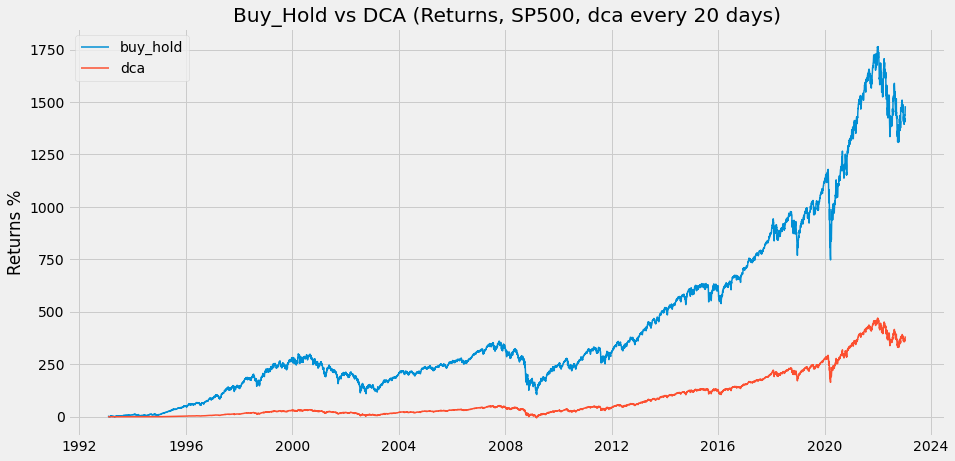

In [5]:
with plt.style.context('fivethirtyeight'):
    fig = plt.figure(figsize=(14,7))
    plt.plot(df.index, df['buy_hold_return'] * 100, linewidth=1.5, label='buy_hold')
    plt.plot(df.index, df['dca_return'] * 100, linewidth=1.5, label='dca')
    
    plt.title("Buy_Hold vs DCA (Returns, SP500, dca every 20 days)")
    plt.ylabel('Returns %')
    plt.legend()

## Drawdown

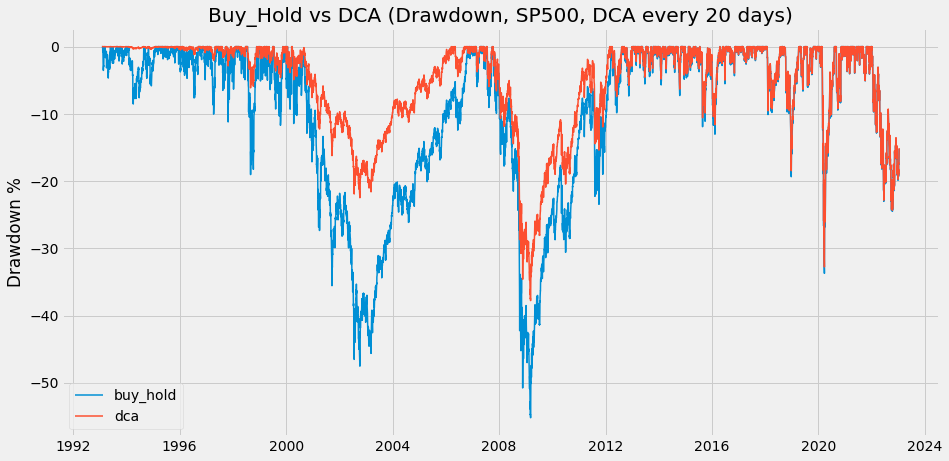

In [11]:
with plt.style.context('fivethirtyeight'):
    fig = plt.figure(figsize=(14,7))
    plt.plot(df.index, df['buy_hold_drawdown'] * 100, linewidth=1.5, label='buy_hold')
    plt.plot(df.index, df['dca_drawdown'] * 100, linewidth=1.5, label='dca')
    


    plt.title("Buy_Hold vs DCA (Drawdown, SP500, DCA every " + str(dca_period) + " days)")
    plt.ylabel('Drawdown %')
    plt.legend()


## Drawdown Distribution

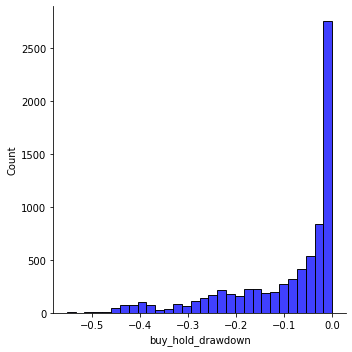

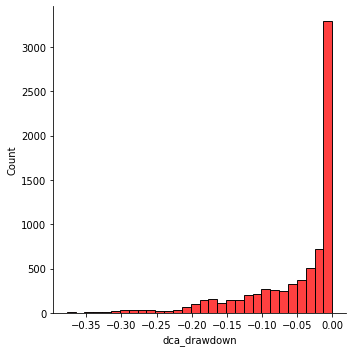

In [7]:
buy_hold = sns.displot(df['buy_hold_drawdown'], color='blue', bins=30)
dca = sns.displot(df['dca_drawdown'], color='red', bins=30)

## Annual Returns Distribution

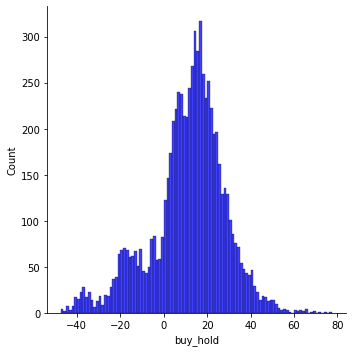

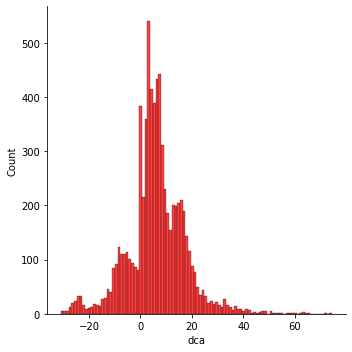

In [8]:
# Rolling Annual Returns
bh_annual_returns = np.array(((df['buy_hold_daily_return'] + 1).rolling(252).apply(np.prod, raw=True) - 1) * 100)
dca_annual_returns = np.array(((df['dca_daily_return'] + 1).rolling(252).apply(np.prod, raw=True) - 1) * 100)

annual_returns = pd.DataFrame({'buy_hold': bh_annual_returns, 'dca': dca_annual_returns})

sns.displot(annual_returns['buy_hold'], color='blue', bins=100)
sns.displot(annual_returns['dca'], color='red', bins=100)

## Statistics

In [9]:
num_years = len(df) / 252

print('Buy_HODL')
print("Total Returns:              " + "{:.2f}".format(df['buy_hold_return'][-1] * 100) + " %")
print("CAGR:                       " + "{:.2f}".format(((df['buy_hold_return'][-1] + 1) ** (1 / num_years) - 1) * 100) + " %")
print("Maximum Drawdown:          " + "{:.2f}".format(np.min(df['buy_hold_drawdown'] * 100)) + " %")
bh_dr_mean = np.mean(df['buy_hold_daily_return'])
bh_dr_var = np.var(df['buy_hold_daily_return'])
bh_ar_mean = (bh_dr_mean + 1) ** 252 - 1
bh_ar_var = bh_dr_var * np.sqrt(252)
print("Annual Returns Mean:        " + "{:.2f}".format(bh_ar_mean * 100) + " %")
print("Annual Returns Std Dev:     " + "{:.2f}".format(np.sqrt(bh_ar_var) * 100) + " %")
print("99% Worst Annual Drawdown: " + "{:.2f}".format(bh_ar_mean - 2.33 * np.sqrt(bh_ar_var) * 100) + " %")

print()

print('DCA')
print("Total Returns:              " + "{:.2f}".format(df['dca_return'][-1] * 100) + " %")
print("CAGR:                       " + "{:.2f}".format(((df['dca_return'][-1] + 1) ** (1 / num_years) - 1) * 100) + " %")
print("Maximum Drawdown:          " + "{:.2f}".format(np.min(df['dca_drawdown'] * 100)) + " %")
dca_dr_mean = np.mean(df['dca_daily_return'])
dca_dr_var = np.var(df['dca_daily_return'])
dca_ar_mean = (dca_dr_mean + 1) ** 252 - 1
dca_ar_var = dca_dr_var * np.sqrt(252)
print("Annual Returns Mean:        " + "{:.2f}".format(dca_ar_mean * 100) + " %")
print("Annual Returns Std Dev:     " + "{:.2f}".format(np.sqrt(dca_ar_var) * 100) + " %")
print("99% Worst Annual Drawdown: " + "{:.2f}".format(dca_ar_mean - 2.33 * np.sqrt(dca_ar_var) * 100) + " %")

Buy_HODL
Total Returns:              1480.21 %
CAGR:                       9.66 %
Maximum Drawdown:          -55.19 %
Annual Returns Mean:        11.64 %
Annual Returns Std Dev:     4.75 %
99% Worst Annual Drawdown: -10.95 %

DCA
Total Returns:              383.10 %
CAGR:                       5.40 %
Maximum Drawdown:          -37.77 %
Annual Returns Mean:        6.23 %
Annual Returns Std Dev:     3.14 %
99% Worst Annual Drawdown: -7.25 %
